In [23]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from data_retriever import DataRetriever
from data_preprocessor import DataPreprocessor
from adstock import Adstock
from metrics import r_squared, rmse, nrmse, mape, smape
from attribution import SHAPAttribution
from visualization import attribution_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Config
PATH_TO_DB = './data.db'
TARGET = 'revenue'
MEDIA_VARIABLES = [
    'tv_S', 
    'ooh_S', 
    'print_S', 
    'search_S', 
    'facebook_S', 
    'newsletter'
]
CONTROL_VARIABLES = (
    ['competitor_sales_B', 'event1', 'event2']
)

In [25]:
# Data 
dr = DataRetriever(
    db=PATH_TO_DB,
    start_dt=datetime.fromisoformat('2015-11-23'),
    end_dt=datetime.fromisoformat('2019-11-11')
)
data = dr.retrieve()

In [26]:
# Preprocessing
dp = DataPreprocessor(data, MEDIA_VARIABLES, CONTROL_VARIABLES, TARGET)
X, y = dp.compute_X_y()

In [27]:
# Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=0, 
    shuffle=False, 
    test_size=0.2
)

In [28]:
# Model
feature_weights_values = {
    "tv_S": 1.2,
    "ooh_S": 1.2,
    "print_S": 1.2,
    "search_S": 1.2,
    "competitor_sales_B": 1.0,
    "facebook_S": 1.2,
    "newsletter": 1.2,
    "event1": 1.0,
    "event2": 1.0,
}
feature_weights = {
    i:feature_weights_values[k] for i,k in enumerate(X_train.columns.tolist())
}

monotone_constraints = {
    int(np.where(X_train.columns == col)[0][0]): 1 for col in MEDIA_VARIABLES
}

model = {
    'estimator': CatBoostRegressor(
        loss_function = 'RMSE',
        has_time = True,
        early_stopping_rounds = 5,
        eval_metric = 'RMSE',
        feature_weights = feature_weights,
        monotone_constraints = monotone_constraints
    ), 
    'param_distributions': dict(
        adstock__adstock__theta = [0.1, 0.2, 0.3],
        estimator__learning_rate = [0.05, 0.1],
        estimator__depth = [4, 6, 8],
        estimator__l2_leaf_reg = [2, 4, 8, 10],
    ),
}

In [29]:
# Fit
estimator = model['estimator']
param_distributions = model['param_distributions']
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
adstock = ColumnTransformer([
        ('adstock', Adstock(), MEDIA_VARIABLES),
        ], 
        remainder='passthrough'
)
pipe = Pipeline([
    ('adstock', adstock), 
    ('estimator', estimator)
])
tscv = TimeSeriesSplit(n_splits=5)
reg = RandomizedSearchCV(
    estimator=pipe, 
    cv=tscv,
    param_distributions=param_distributions, 
    scoring=scoring, 
    refit=True,
    random_state=0,
    n_iter=20,
    error_score = 'raise'
)
search = reg.fit(X_train, y_train, estimator__verbose=False)
print(search.best_params_)

{'estimator__learning_rate': 0.05, 'estimator__l2_leaf_reg': 2, 'estimator__depth': 4, 'adstock__adstock__theta': 0.3}


In [30]:
# Performance metrics
performance_metrics = []
y_test_hat = search.predict(X_test)
metrics_test = {
    'model': f'{estimator.__class__.__name__}',
    'dataset': 'test',
    'r_squared': r_squared(y_test, y_test_hat),
    'rmse': rmse(y_test, y_test_hat),
    'nrmse': nrmse(y_test, y_test_hat),
    'mape': mape(y_test, y_test_hat),
    'smape': smape(y_test, y_test_hat),
}
performance_metrics.append(metrics_test)
y_train_hat = search.predict(X_train)
metrics_train = {
    'model': f'{estimator.__class__.__name__}',
    'dataset': 'train',
    'r_squared': r_squared(y_train, y_train_hat),
    'rmse': rmse(y_train, y_train_hat),
    'nrmse': nrmse(y_train, y_train_hat),
    'mape': mape(y_train, y_train_hat),
    'smape': smape(y_train, y_train_hat),
}
performance_metrics.append(metrics_train)
performance_metrics = pd.DataFrame(performance_metrics)
performance_metrics

,model,dataset,r_squared,rmse,nrmse,mape,smape
0,CatBoostRegressor,test,0.791921,297687.997959,0.142058,0.179212,0.151780
1,CatBoostRegressor,train,0.978947,104364.661221,0.033663,0.044521,0.044567


In [31]:
search.best_params_

{'estimator__learning_rate': 0.05,
 'estimator__l2_leaf_reg': 2,
 'estimator__depth': 4,
 'adstock__adstock__theta': 0.3}

In [32]:
# Attribution
adstock = Adstock(theta=search.best_params_['adstock__adstock__theta'])
X_test_adstock = adstock.fit_transform(X_test)
X_test_adstock = pd.DataFrame(X_test_adstock, columns=X_test.columns, index=X_test.index)
attribution = SHAPAttribution(
    model=search.best_estimator_['estimator'],
    media_variables=MEDIA_VARIABLES,
    control_variables=CONTROL_VARIABLES
)
attribution_df = attribution.fit_transform(X_test_adstock)

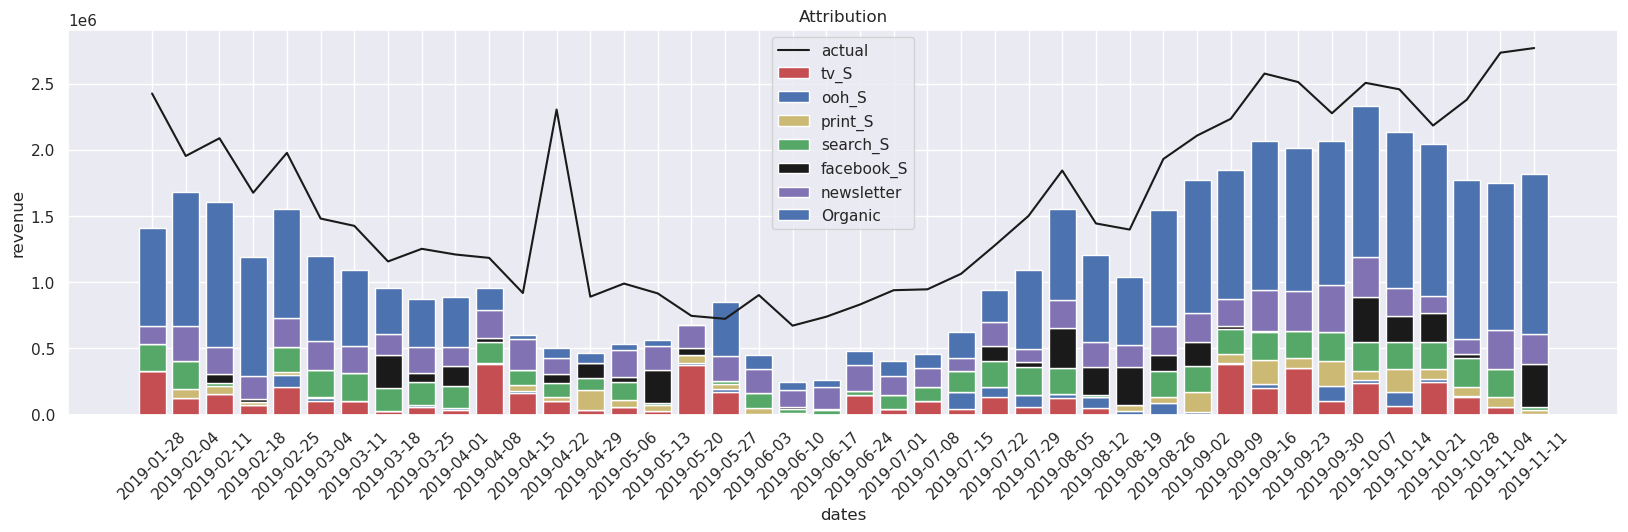

In [33]:
# Plot
attribution_plot(
    attribution_df, 
    TARGET, 
    data.loc[data.index.isin(attribution_df.index), 'revenue']
)